In [37]:
import networkx as nx

G = nx.Graph()
G = nx.read_gml('power_grid.gml', label=None)

In [38]:
def is_acyclic(G):
    return nx.cycle_basis(G) == []

def print_relevant_info(G):
    print("Number of nodes: ", G.number_of_nodes())
    print("Number of edges: ", G.number_of_edges())
    print("Network has no cycles: ", is_acyclic(G))

print_relevant_info(G)

Number of nodes:  4941
Number of edges:  6594
Network has no cycles:  False


In [39]:
def bfs_by_ratio(G, node, max_dist):
    visited = [node]
    queue = [node]
    distance = [-1]*(G.number_of_nodes() + 1)
    distance [node] = 0
    while queue:
        node = queue.pop(0)
        for neighbour in G.neighbors(node):
            if neighbour not in visited and distance[node] + 1 <= max_dist:
                visited.append(neighbour)
                queue.append(neighbour)
                distance[neighbour] = distance[node] + 1
    return len(visited)

def diego_centrality(G, ratio=3):
    centrality = {}
    for node in G.nodes:
        centrality[node] = bfs_by_ratio(G, node, ratio)
    return centrality
        

In [40]:
def get_best_nodes_by_centrality(centrality_funtion, G, number_of_nodes):
    centrality_values = centrality_funtion(G)
    amount = 0
    aux = list((b, a) for a, b in centrality_values.items())
    aux.sort(reverse=True)
    ret = []
    for i in aux:
        if amount >= number_of_nodes:
            break
        amount += 1
        ret.append(i)
    return ret


In [41]:
def get_intersection(list1, list2):
    return list(set(list1) & set(list2))

def get_intersections(result1, result2, max_size):
    list1 = []
    list2 = []
    result = [[]]
    for size in range(max_size):
        list1.append(result1[size][1])
        list2.append(result2[size][1])
        result.append(get_intersection(list1, list2))
    return result

#get_intersections(nx.betweenness_centrality, nx.degree_centrality, G, 100)

In [42]:
best = []
amount = 209
best.append(get_best_nodes_by_centrality(nx.degree_centrality, G, amount))                      #degree centrality      (0)
print(0)
best.append(get_best_nodes_by_centrality(nx.pagerank, G, amount))                               #pagerank               (1)
print(1)
best.append(get_best_nodes_by_centrality(nx.subgraph_centrality, G, amount))                    #Subgraph centrality    (2)
print(2)
best.append(get_best_nodes_by_centrality(diego_centrality, G, amount))                          #New centrality         (3)
print(3)

0
1
2
3


In [43]:
from itertools import combinations

for i, j in combinations(range(len(best)), 2):
    aux = [len(x) for x in get_intersections(best[i], best[j], amount)]
    print(i, j," -> ", aux[-1], end = '\n')

0 1  ->  166
0 2  ->  143
0 3  ->  96
1 2  ->  103
1 3  ->  72
2 3  ->  92


In [44]:
generators = get_intersection([x[1] for x in best[0]], [x[1] for x in best[1]])
generators = get_intersection(generators, [x[1] for x in best[2]])
generators = get_intersection(generators, [x[1] for x in best[3]])
print(generators, len(generators))

[2561, 2434, 1030, 2439, 2574, 2575, 1166, 2959, 1170, 4373, 2585, 2586, 2458, 2717, 1309, 2596, 680, 681, 4395, 2604, 2553, 2607, 2608, 2554, 2485, 1334, 2617, 2235, 2493, 1090, 1091, 2883, 3783, 4172, 1106, 2522, 4187, 4448, 1506, 2533, 2662, 4199, 2918, 4346, 4458, 490, 2538, 2542, 3312, 2545, 1140, 2548, 2936, 4345, 4218, 639] 56


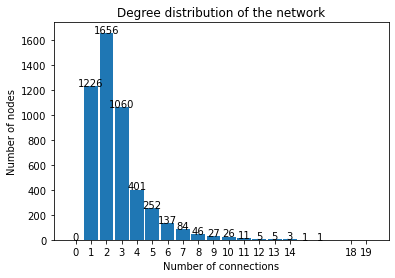

In [45]:
import numpy as np
import matplotlib.pyplot as plt

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

degree_distribution = {}
for i in G.degree:
    if i[1] in degree_distribution:
        degree_distribution[i[1]] += 1
    else:
        degree_distribution[i[1]] = 1

aux = [(x, y) for (x, y) in degree_distribution.items()]
aux.sort()
x = [0]
y = [0]

for i in aux:
    x.append(i[0])
    y.append(i[1])

plt.bar(x, y, tick_label=[str(val) for val in x], width=0.9)
plt.title("Degree distribution of the network")

addlabels(x,y)
plt.xlabel("Number of connections")
plt.ylabel("Number of nodes")
plt.savefig("Deg_distribution.jpg", dpi=300)
plt.show()

In [46]:
from matplotlib import pylab
pos = nx.spring_layout(G)


In [66]:
colors = []
size_node = []
edges_color = '#ffdc73'

def set_colors(gen_color, norm_color, terminal_color):
    global colors
    global size_node
    colors = []
    size_node = []
    for node in G.nodes:
        if node in generators:
            colors.append(gen_color)
            size_node.append(160)
        else:
            if G.degree[node] != 1:
                colors.append(norm_color)
                size_node.append(20)
            else:
                colors.append(terminal_color)
                size_node.append(40)

set_colors('#23ccad', '#c70039', 'black')

In [71]:
def save_graph(graph,file_name, color_edges = ['#ffdc73' for u, v in G.edges]):
    plt.figure(num=None, figsize=(30, 30), dpi=160)
    plt.axis('off')
    fig = plt.figure(1)
    
    nx.draw_networkx(graph, pos, with_labels=False, node_size=size_node, node_color=colors, edge_color=color_edges)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    xmin = cut * min(xx for xx, yy in pos.values())
    ymin = cut * min(yy for xx, yy in pos.values())
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig

save_graph(G,"my_graph.pdf")

In [50]:
G_aux = G.copy()
gen2 = generators.copy()
for node in gen2:
    print(node, end = ' ')
    G_aux.remove_node(node)
    print(nx.is_connected(G_aux), end=' ')


2561 True 2434 False 1030 False 2439 False 2574 False 2575 False 1166 False 2959 False 1170 False 4373 False 2585 False 2586 False 2458 False 2717 False 1309 False 2596 False 680 False 681 False 4395 False 2604 False 2553 False 2607 False 2608 False 2554 False 2485 False 1334 False 2617 False 2235 False 2493 False 1090 False 1091 False 2883 False 3783 False 4172 False 1106 False 2522 False 4187 False 4448 False 1506 False 2533 False 2662 False 4199 False 2918 False 4346 False 4458 False 490 False 2538 False 2542 False 3312 False 2545 False 1140 False 2548 False 2936 False 4345 False 4218 False 639 False 

In [51]:
articulation_points = list(nx.articulation_points(G))
articulation_generators = get_intersection(articulation_points, generators)
print(articulation_generators, len(articulation_generators))

[2434, 1030, 2439, 2574, 2575, 1166, 2959, 2586, 2717, 1309, 680, 4395, 2604, 2608, 1334, 2493, 1090, 3783, 1106, 2522, 4187, 4448, 1506, 2662, 4199, 4458, 490, 2542, 1140, 2548, 2936, 2553, 4218, 639] 34


In [52]:
colors = []
size_node = []

for node in G.nodes:
    if node in articulation_generators:
        colors.append('#23ccad')
        size_node.append(250)
    else:
        colors.append('black')
        size_node.append(20)
save_graph(G,"articulation_points.pdf")

In [53]:
distances_family = [(100, -1)]*(G.number_of_nodes() + 1)
#(distance, family)

def BFS_family(init_node):
    queue = [init_node]
    global distances_family    
    distances_family [init_node] = (0, init_node)
    while queue:
        node = queue.pop(0)
        for neighbour in G.neighbors(node):
            if distances_family[node][0] + 1 <= distances_family[neighbour][0]:
                queue.append(neighbour)
                distances_family[neighbour] = (distances_family[node][0] + 1, init_node)

for node in generators:
    BFS_family(node)

#print(distances_family)

In [83]:
colors = []
size_node = []

usable_colors = {}
for i in range(len(generators)):
    usable_colors[generators[i]] = float(i)/float(len(generators))

communities = {}

for node in G.nodes:
    family = distances_family[node][1]
    if family not in communities.keys():
        communities[family] = [node]
    else:
        communities[family].append(node)
    colors.append(usable_colors[family])
    if node in generators:
        size_node.append(250)
    else:
        size_node.append(50)

edges_color = []

for u,v in G.edges:
    family_u = distances_family[u][1]
    family_v = distances_family[v][1]
    if family_u == family_v:
        edges_color.append(usable_colors[family_u])
    else:
        edges_color.append(1)

save_graph(G,"communities.pdf", color_edges=edges_color)


In [84]:
def save_graph_community(graph,file_name, list_of_nodes, color):
    plt.figure(num=None, figsize=(30, 30), dpi=160)
    plt.axis('off')
    fig = plt.figure(1)

    size_of_nodes = []
    for node in list_of_nodes:
        if node not in generators:
            size_of_nodes.append(100)
        else:
            size_of_nodes.append(500)

    list_of_edges = []
    for u, v in G.edges:
        if u in list_of_nodes and v in list_of_nodes:
            list_of_edges.append((u,v))

    nx.draw_networkx(graph, pos, with_labels=False, edgelist=list_of_edges, nodelist=list_of_nodes, node_size=size_of_nodes, node_color=color, edge_color=color)

    cut = 1.00
    xmax = cut * max(xx for xx, yy in pos.values())
    ymax = cut * max(yy for xx, yy in pos.values())
    xmin = cut * min(xx for xx, yy in pos.values())
    ymin = cut * min(yy for xx, yy in pos.values())
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    
    plt.savefig(file_name,bbox_inches="tight")
    pylab.close()
    del fig

In [98]:
size_of_communities = [len(communities[main_node]) for main_node in generators]
i = 0
number_of_printed = len([size_of_community for size_of_community in size_of_communities if size_of_community > 100])
print(number_of_printed)
list_of_colors = ['#e6194B', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#42d4f4', '#f032e6', '#469990', '#9A6324', '#800000', '#808000', '#000075', '#a9a9a9', '#000000']
for community in communities.values():
    if len(community) > 100:
        i += 1
        actual_name = "Community_size_"+str(len(community))+".jpg"
        save_graph_community(G, actual_name, community, list_of_colors[i])

14
